In [1]:
%matplotlib inline
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests

In [20]:
#data = requests.get('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&outputsize=full&apikey=T694IP72UNMJTRME&datatype=csv')
dataset_train = pd.read_csv('daily_MSFT.csv')

training_set = dataset_train.iloc[:, 1:2].values

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, 5368):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(
        input_shape = (X_train.shape[1], 1),
        units = 100,
        return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
        100,
        return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.add(Activation('linear'))

model.compile(loss = 'mse', optimizer = 'rmsprop')

In [26]:
model.fit(
        X_train,
        y_train,
        batch_size = 512,
        epochs = 2,
        validation_split = 0.05)

Train on 5042 samples, validate on 266 samples
Epoch 1/2
5042/5042 [==============================] - 25s 5ms/step - loss: 0.0617 - val_loss: 0.0592
Epoch 2/2
5042/5042 [==============================] - 19s 4ms/step - loss: 0.0078 - val_loss: 0.0168


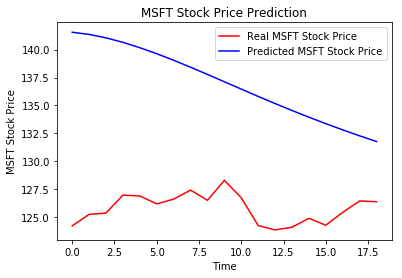

In [30]:
dataset_test = pd.read_csv('daily_MSFT_test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

# Getting the predicted stock price
dataset_total = pd.concat((dataset_train['open'], dataset_test['open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 79):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

#Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real MSFT Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted MSFT Stock Price')
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MSFT Stock Price')
plt.legend()
plt.show()